In [69]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
from modelfitting import train_test_split, ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [2]:
datapath = '../training_data/'
dset = 'resonant/'
Norbits = 1e4
Nout = 80
featureargs = (Norbits, Nout) # params to pass feature function
featurefolder = 'featuresNorbits{0:.1f}Nout{1}trio/'.format(Norbits, Nout)
trainingdatafolder = datapath+dset+featurefolder

In [48]:
space ={'max_depth': hp.qloguniform('x_max_depth', np.log(5), np.log(20), 1),
        'min_child_weight': hp.loguniform('x_min_child', 0, np.log(20)),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
}

def objective(params):
    clf = XGBClassifier(n_estimators = 50,
                            max_depth = int(params['max_depth']), 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            learning_rate = 0.2, seed = 0)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    print("SCORE:", avg_score, "ERROR", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}

In [24]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno

trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

In [49]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 100, trials = trials, rstate=np.random.RandomState(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                               
0.9366319000000001                                   
ERROR                                                
0.0016308992972406129                                
SCORE:                                                                         
0.9361297000000001                                                             
ERROR                                                                          
0.0016863960716326665                                                          
SCORE:                                                                         
0.93512208                                                                     
ERROR                                                                          
0.0015309349831714738                                                          
SCORE:                                                                         
0.9325518599999999                                              

ERROR                                                                           
0.0016803982172581735                                                           
SCORE:                                                                          
0.9369224199999999                                                              
ERROR                                                                           
0.001865490059901801                                                            
SCORE:                                                                          
0.9363862800000001                                                              
ERROR                                                                           
0.0017341849770136312                                                           
SCORE:                                                                          
0.9363400000000001                                                              
ERROR                       

0.0017384651262306976                                                           
SCORE:                                                                          
0.9267800599999999                                                              
ERROR                                                                           
0.0021527820390948326                                                           
SCORE:                                                                          
0.9352273400000002                                                              
ERROR                                                                           
0.0019337774786585017                                                           
SCORE:                                                                          
0.9368126800000001                                                              
ERROR                                                                           
0.0016801411284855026       

SCORE:                                                                          
0.9366806000000001                                                              
ERROR                                                                           
0.0016266219347170446                                                           
SCORE:                                                                          
0.9363556999999998                                                              
ERROR                                                                           
0.0014551557113472106                                                           
SCORE:                                                                          
0.93577078                                                                      
ERROR                                                                           
0.0013869428134979864                                                           
SCORE:                      

# max_depth controls depth of trees

12 lets the model use all the features and improvements seem minor beyond that

Text(0, 0.5, 'CV AUC')

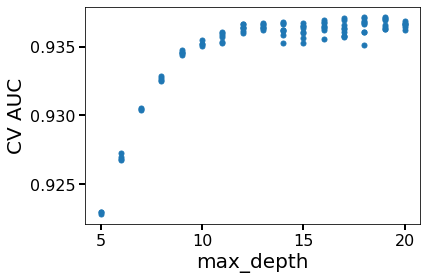

In [74]:
depths = trials.vals['x_max_depth']
min_childs = trials.vals['x_min_child']
aucs = np.array([1-x['loss'] for x in trials.results])

fig, ax = plt.subplots()
ax.plot(depths, aucs, '.')
ax.set_xlabel('max_depth')
ax.set_ylabel('CV AUC')

# min child weight acts as a regularizer, penalizing complex models. Larger min_child_weight = larger penalization

Text(0, 0.5, 'CV AUC')

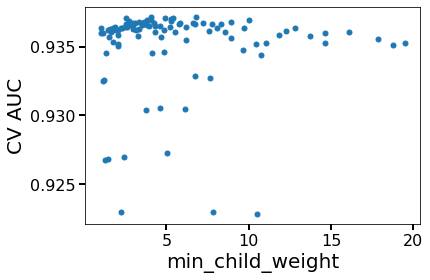

In [75]:
fig, ax = plt.subplots()
ax.plot(min_childs, aucs, '.')
ax.set_xlabel('min_child_weight')
ax.set_ylabel('CV AUC')

Text(0, 0.5, 'min_child_weight')

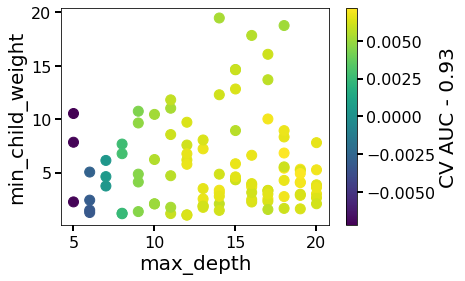

In [83]:
fig, ax = plt.subplots()
cb = ax.scatter(depths, min_childs, c=aucs-0.93)
plt.colorbar(cb, label='CV AUC - 0.93')
ax.set_xlabel('max_depth')
ax.set_ylabel('min_child_weight')

# Marginal improvements beyond max_depth of 12, so choose the least complex model

In [65]:
model = XGBClassifier(learning_rate = 0.05, 
                         max_depth = 12, 
                         subsample = 0.95,
                         min_child_weight = 5)

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=400)

[0]	train-auc:0.94607+0.00047	test-auc:0.92236+0.00171
[1]	train-auc:0.95368+0.00077	test-auc:0.92982+0.00154
[2]	train-auc:0.95708+0.00088	test-auc:0.93241+0.00174
[3]	train-auc:0.95877+0.00075	test-auc:0.93383+0.00178
[4]	train-auc:0.96028+0.00076	test-auc:0.93508+0.00164
[5]	train-auc:0.96182+0.00066	test-auc:0.93626+0.00149
[6]	train-auc:0.96290+0.00065	test-auc:0.93692+0.00162
[7]	train-auc:0.96377+0.00051	test-auc:0.93759+0.00166
[8]	train-auc:0.96441+0.00055	test-auc:0.93797+0.00170
[9]	train-auc:0.96516+0.00050	test-auc:0.93839+0.00179
[10]	train-auc:0.96578+0.00047	test-auc:0.93884+0.00169
[11]	train-auc:0.96646+0.00049	test-auc:0.93919+0.00170
[12]	train-auc:0.96708+0.00046	test-auc:0.93948+0.00164
[13]	train-auc:0.96762+0.00047	test-auc:0.93978+0.00172
[14]	train-auc:0.96810+0.00048	test-auc:0.94008+0.00173
[15]	train-auc:0.96865+0.00043	test-auc:0.94037+0.00179
[16]	train-auc:0.96920+0.00041	test-auc:0.94070+0.00176
[17]	train-auc:0.96972+0.00039	test-auc:0.94090+0.00167
[1

[146]	train-auc:0.98887+0.00010	test-auc:0.95008+0.00134
[147]	train-auc:0.98897+0.00011	test-auc:0.95012+0.00134
[148]	train-auc:0.98906+0.00013	test-auc:0.95016+0.00133
[149]	train-auc:0.98916+0.00013	test-auc:0.95021+0.00132
[150]	train-auc:0.98923+0.00017	test-auc:0.95023+0.00133
[151]	train-auc:0.98929+0.00014	test-auc:0.95027+0.00135
[152]	train-auc:0.98939+0.00017	test-auc:0.95030+0.00134
[153]	train-auc:0.98946+0.00018	test-auc:0.95034+0.00135
[154]	train-auc:0.98953+0.00018	test-auc:0.95038+0.00135
[155]	train-auc:0.98957+0.00017	test-auc:0.95039+0.00135
[156]	train-auc:0.98962+0.00017	test-auc:0.95040+0.00136
[157]	train-auc:0.98971+0.00017	test-auc:0.95044+0.00132
[158]	train-auc:0.98977+0.00016	test-auc:0.95045+0.00132
[159]	train-auc:0.98981+0.00016	test-auc:0.95046+0.00133
[160]	train-auc:0.98987+0.00019	test-auc:0.95048+0.00133
[161]	train-auc:0.98992+0.00020	test-auc:0.95051+0.00132
[162]	train-auc:0.98997+0.00019	test-auc:0.95052+0.00132
[163]	train-auc:0.99003+0.00017

[290]	train-auc:0.99499+0.00017	test-auc:0.95226+0.00121
[291]	train-auc:0.99501+0.00017	test-auc:0.95227+0.00122
[292]	train-auc:0.99504+0.00017	test-auc:0.95229+0.00122
[293]	train-auc:0.99507+0.00016	test-auc:0.95230+0.00120
[294]	train-auc:0.99511+0.00016	test-auc:0.95231+0.00121
[295]	train-auc:0.99513+0.00016	test-auc:0.95231+0.00120
[296]	train-auc:0.99516+0.00015	test-auc:0.95232+0.00121
[297]	train-auc:0.99518+0.00016	test-auc:0.95232+0.00121
[298]	train-auc:0.99519+0.00016	test-auc:0.95233+0.00121
[299]	train-auc:0.99521+0.00016	test-auc:0.95233+0.00121
[300]	train-auc:0.99524+0.00016	test-auc:0.95234+0.00122
[301]	train-auc:0.99525+0.00017	test-auc:0.95235+0.00122
[302]	train-auc:0.99528+0.00018	test-auc:0.95236+0.00122
[303]	train-auc:0.99531+0.00017	test-auc:0.95237+0.00120
[304]	train-auc:0.99534+0.00017	test-auc:0.95238+0.00120
[305]	train-auc:0.99537+0.00015	test-auc:0.95239+0.00120
[306]	train-auc:0.99539+0.00016	test-auc:0.95240+0.00120
[307]	train-auc:0.99541+0.00016

# Going beyond ~100 trees does not improve CV, so cut off training there to avoid overfitting

Text(0, 0.5, 'CV AUC score')

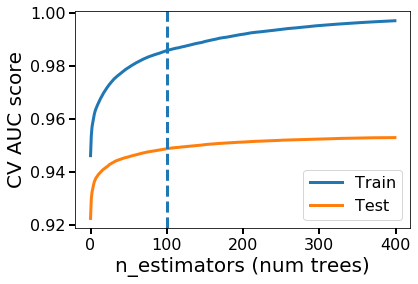

In [84]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-auc-mean'], label='Train')
ax.plot(score.index, score['test-auc-mean'], label='Test')
ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

In [85]:
model.set_params(n_estimators = n_estimators)
model.fit(trainX, trainY)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=12,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.95,
              tree_method=None, validate_parameters=False, verbosity=None)

In [86]:
model.save_model(datapath+'../spock/models/spock.json')

In [87]:
model = XGBClassifier()
model.load_model(datapath+'../spock/models/spock.json')

# SPOCK

Text(0.5, 1.0, 'ROC curve (AUC = 0.952)')

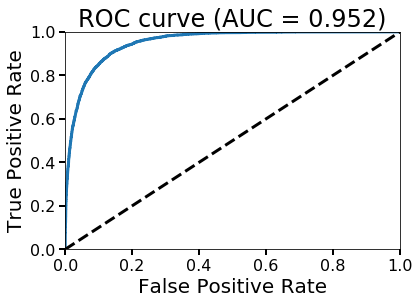

In [88]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [89]:
for i in range(0,len(tpr), 15):
    print("Threshold {0}, TPR = {1}, FPR = {2}".format(ROCthresholds[i], tpr[i], fpr[i]))

Threshold 1.9888850450515747, TPR = 0.0, FPR = 0.0
Threshold 0.9569470286369324, TPR = 0.07590634441087614, FPR = 0.00028714179061620627
Threshold 0.9464539885520935, TPR = 0.10441842900302115, FPR = 0.0006317119393556538
Threshold 0.9358454346656799, TPR = 0.1351963746223565, FPR = 0.0012059955205880664
Threshold 0.9253713488578796, TPR = 0.16748489425981872, FPR = 0.0016079940274507552
Threshold 0.9133983254432678, TPR = 0.2048716012084592, FPR = 0.0021248492505599264
Threshold 0.9053751826286316, TPR = 0.22658610271903323, FPR = 0.002526847757422615
Threshold 0.9018480181694031, TPR = 0.236404833836858, FPR = 0.0029862746224085454
Threshold 0.8966063857078552, TPR = 0.24962235649546827, FPR = 0.003388273129271234
Threshold 0.8882840275764465, TPR = 0.2711480362537764, FPR = 0.003847699994257164
Threshold 0.8832039833068848, TPR = 0.2836102719033233, FPR = 0.004249698501119853
Threshold 0.8757122755050659, TPR = 0.29928247734138974, FPR = 0.004766553724229025
Threshold 0.870640635490

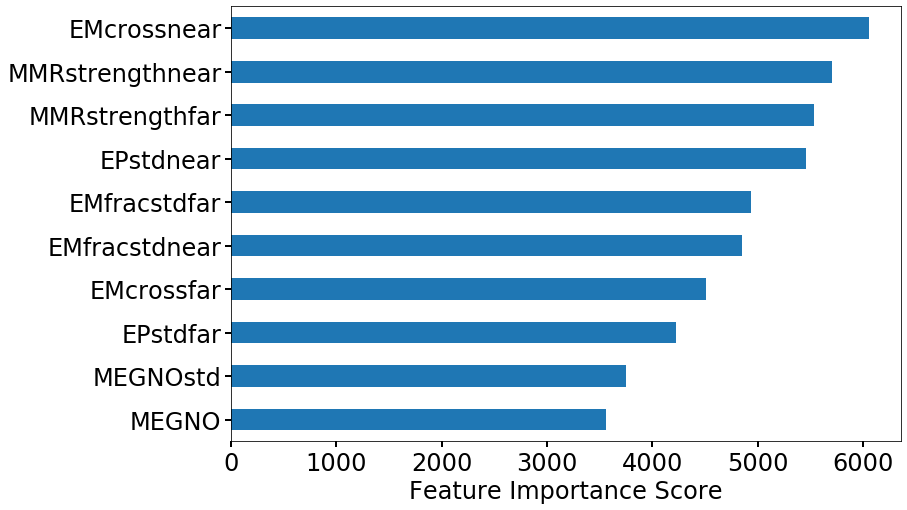

In [90]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

In [100]:
feat_imp

EMcrossnear        6052
MMRstrengthnear    5703
MMRstrengthfar     5533
EPstdnear          5456
EMfracstdfar       4940
EMfracstdnear      4846
EMcrossfar         4505
EPstdfar           4227
MEGNOstd           3751
MEGNO              3564
dtype: int64

(0, 355.3)

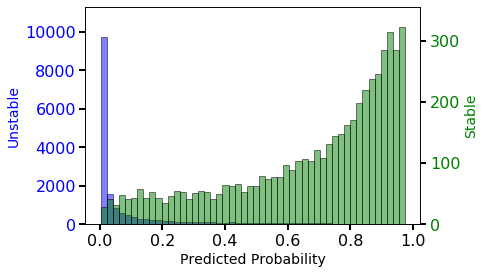

In [92]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, patches = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    
ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
       
ax1.set_ylim([0,35*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

Text(0, 0.5, 'Fraction actually stable')

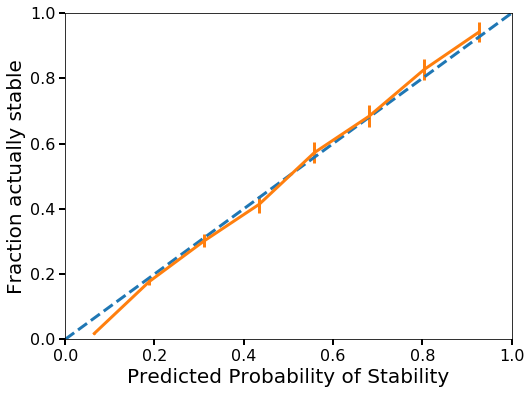

In [93]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=8)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

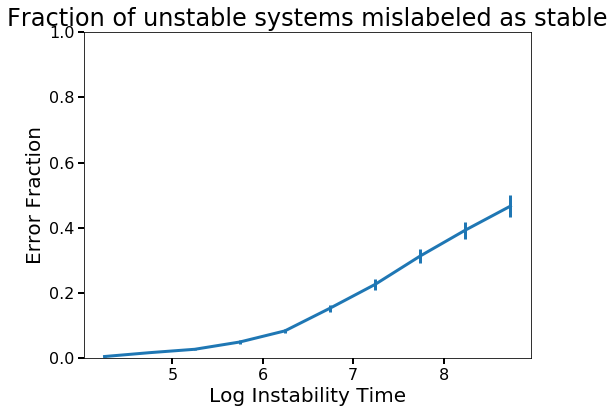

In [94]:
thresh = 0.34 # for 10% FPR
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, thresh, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')